<h1><center>智能商务分析实践（Python）: 个人信贷违约预测

**小组成员**
```
朱一凡
```
**工作日志**
```
1. 2022-11-29 导入数据，进行简单处理，并通过一些模型简单预测练手

2. 2022-11-30 对数据进行预处理，通过学习泰坦尼克号的例子，对数据中的缺省值进行了均值替换
              其间遇到了数据中无法提取work_year的问题，最后采用正则提取完成此目标
              
3. 2022-12-1 对数据进行异常值处理，考虑不清楚各个特征情况，先用盒型图描述，将其中明
             显有较多异常值的特征提取出来，然后因为不知道如何获得这些特征的异常值个
             数，最后求助同学得到detect_outliers1函数，对异常值较少的选择删去，对
             异常值较多的选择用均值替换异常值
             
4. 2022-12-2 描述性统计分析，在初次建模时，因为employer_type和industry数据类型为
             str，所以再回到数据预处理中对数据进行虚拟化处理，同时修改描述性统计分
             析使其运行正常
             
5. 2022-12-9 选择𝑘 阶近邻算法对数据进行预测分析，并且使用k为10的k折交叉验证，计算
             precision和recall，计算ROC曲线下面积AUC，最后通过测试数据对模型预测
             能力进行评价
```

**<h3>一、数据导入**

In [407]:
import pandas as pd
import numpy as np
%matplotlib inline
loan_data = pd.read_csv("zhongyuan_train.csv",low_memory=False)
loan_data.head

<bound method NDFrame.head of       Unnamed: 0  loan_id  user_id   total_loan  year_of_loan  interest  \
0              0  1040418   240418  31818.18182             3    11.466   
1              1  1025197   225197  28000.00000             5    16.841   
2              2  1009360   209360  17272.72727             3     8.900   
3              3  1039708   239708  20000.00000             3     4.788   
4              4  1027483   227483  15272.72727             3    12.790   
...          ...      ...      ...          ...           ...       ...   
7495        9993  1009983   209983  24545.45455             5    20.889   
7496        9995  1028093   228093  17727.27273             3    15.037   
7497        9996  1043911   243911  13636.36364             3     6.534   
7498        9997  1023503   223503  24818.18182             3    14.421   
7499        9999  1021034   221034   1000.00000             3    14.014   

      monthly_payment class employer_type         industry  ... polic

In [408]:
loan_data_clean = loan_data.drop(columns = ['loan_id','user_id','issue_date','post_code','region','earlies_credit_mon','policy_code','f0','f1','f2','f3','f4'],axis=1)

**<h3>二、数据的预处理**

<b>2.1缺省值处理

In [409]:
loan_data_clean[loan_data_clean.isnull().any(axis=1)]
#    找出一行中有NULL的行(axis = 0)  any表示与操作，只要有一个为NULL就可以找出

,Unnamed: 0,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,...,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,early_return,early_return_amount,early_return_amount_3mon,isDefault
6,8,6818.181818,3,20.064,272.05,D,普通企业,金融业,NaN,0,...,1.0,18810.000000,88.615385,0,0,0,0,0,0.0,0
9,11,6400.000000,3,20.889,234.57,E,幼教与中小学校,金融业,NaN,2,...,0.0,13980.000000,69.576923,1,0,0,0,0,0.0,0
13,15,5500.000000,3,12.620,184.32,C,普通企业,住宿和餐饮业,NaN,1,...,0.0,7252.000000,29.261538,0,0,0,0,0,0.0,0
43,59,9218.181818,3,16.990,301.23,D,普通企业,文化和体育业,NaN,1,...,0.0,11884.615380,72.000000,0,0,0,0,0,0.0,1
47,64,9818.181818,5,13.545,285.80,C,高等教育机构,文化和体育业,NaN,2,...,0.0,552.692308,6.461538,0,0,3,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,9872,17018.181820,5,16.104,339.86,C,上市企业,公共服务、社会组织,NaN,2,...,0.0,47889.230770,79.700000,1,0,4,0,0,0.0,1
7414,9881,5909.090909,3,7.890,156.43,A,普通企业,电力、热力生产供应业,NaN,1,...,0.0,2304.230769,15.292308,0,0,0,3,83,0.0,0
7428,9902,13090.909090,3,4.788,361.38,A,上市企业,电力、热力生产供应业,NaN,0,...,0.0,5198.769231,6.923077,1,0,5,0,4685,1405.5,0
7451,9934,12054.545450,3,18.205,361.38,D,普通企业,电力、热力生产供应业,NaN,2,...,0.0,8855.000000,17.900000,0,0,0,0,0,0.0,1


475条缺省值，考虑以行业为分组依据，将各组中位数作为work_year的缺失值

In [410]:
len(loan_data_clean['industry'].value_counts())

14

有十四种职业，考虑用正则提取work_year

In [411]:
loan_data_clean['work_year'] = loan_data_clean['work_year'].str.extract('(\d+)', expand=True)

In [412]:
loan_data_clean['work_year'].value_counts()

10    2509
1     1082
2      633
3      584
5      471
4      430
6      354
8      333
7      333
9      303
Name: work_year, dtype: int64

In [413]:
class_mapping={}
for i,j in zip(range(1,11),range(1,11)):
    class_mapping[str(i)]=j

In [414]:
loan_data_clean['work_year']=loan_data_clean['work_year'].map(class_mapping)

In [415]:
loan_data_clean['work_year'].value_counts()

10.0    2509
1.0     1082
2.0      633
3.0      584
5.0      471
4.0      430
6.0      354
8.0      333
7.0      333
9.0      303
Name: work_year, dtype: int64

In [416]:
loan_data_clean.groupby('industry')['work_year']
loan_data_clean.groupby('industry')['work_year'].transform("median")

0       6.0
1       6.0
2       6.0
3       6.0
4       6.0
       ... 
7495    7.0
7496    6.0
7497    6.0
7498    6.0
7499    6.0
Name: work_year, Length: 7500, dtype: float64

In [417]:
loan_data_clean['work_year'].fillna(loan_data_clean.groupby('industry')['work_year'].transform("median"), inplace=True)

In [418]:
loan_data_clean[loan_data_clean.isnull().any(axis=1)]

,Unnamed: 0,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,...,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,early_return,early_return_amount,early_return_amount_3mon,isDefault
966,1318,11818.181820,3,8.320,409.30,A,普通企业,公共服务、社会组织,10.0,2,...,NaN,241.153846,2.300000,1,0,968,2,4115,823.0,0
2024,2729,4909.090909,3,9.218,189.08,A,普通企业,建筑业,1.0,0,...,NaN,7386.000000,48.923077,1,0,40,0,0,0.0,0
2297,3094,4000.000000,3,11.124,133.55,D,高等教育机构,住宿和餐饮业,6.0,1,...,NaN,3147.846154,30.584615,1,0,20784,3,338,101.4,0
3236,4333,13636.363640,3,10.206,493.50,C,上市企业,电力、热力生产供应业,10.0,1,...,NaN,16676.538460,49.000000,1,0,20611,1,2399,0.0,0
4273,5705,818.181818,3,7.120,30.94,A,普通企业,房地产业,1.0,0,...,NaN,2569.615385,3.507692,1,0,20819,0,0,0.0,0
5452,7286,10909.090910,3,7.750,312.22,A,普通企业,住宿和餐饮业,6.0,1,...,NaN,5028.000000,13.030769,1,0,20759,0,0,0.0,1
6877,9192,3081.818182,3,10.604,90.68,B,普通企业,电力、热力生产供应业,3.0,0,...,NaN,60006.153850,11.538462,1,0,20883,0,0,0.0,0


pub_dero_bankrup有7个缺省值，直接删去

In [419]:
loan_data_clean.dropna(inplace = True)
loan_data_clean[loan_data_clean.isnull().any(axis=1)]

,Unnamed: 0,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,...,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,early_return,early_return_amount,early_return_amount_3mon,isDefault


<b>2.2变量虚拟化处理

In [420]:
employer_type_industry_columns=['employer_type','industry']
employer_type_industry_columns_du=pd.get_dummies(loan_data_clean[employer_type_industry_columns])
loan_data_clean=pd.concat([loan_data_clean,employer_type_industry_columns_du],axis=1)

In [421]:
class_dict={
    "class":{
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7}
    }

loan_data_clean=loan_data_clean.replace(class_dict)

loan_data_clean['class'].head()

0    3
1    3
2    1
3    1
4    3
Name: class, dtype: int64

<b>2.3对异常值的处理

In [422]:
loan_data_clean.shape#查看属性个数

(7493, 48)

In [423]:
loan_data_clean.dtypes#查看属性类别

Unnamed: 0                    int64
total_loan                  float64
year_of_loan                  int64
interest                    float64
monthly_payment             float64
class                         int64
employer_type                object
industry                     object
work_year                   float64
house_exist                   int64
censor_status                 int64
use                           int64
debt_loan_ratio             float64
del_in_18month                int64
scoring_low                 float64
scoring_high                float64
known_outstanding_loan        int64
known_dero                    int64
pub_dero_bankrup            float64
recircle_b                  float64
recircle_u                  float64
initial_list_status           int64
app_type                      int64
title                         int64
early_return                  int64
early_return_amount           int64
early_return_amount_3mon    float64
isDefault                   

In [424]:
loan_data_index = list(loan_data_clean.iloc[:,:28].drop(columns=['employer_type','industry']))#列索引名

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


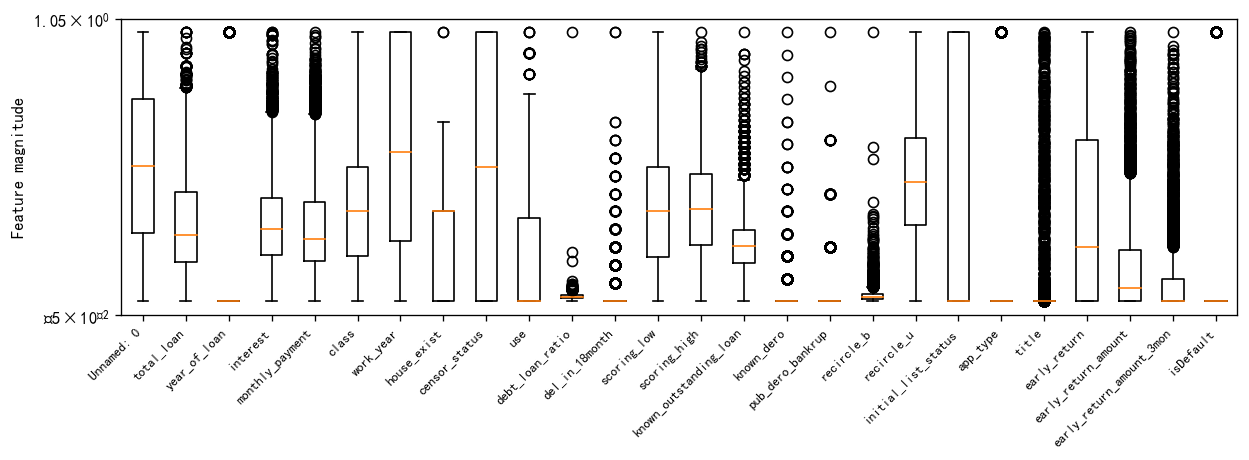

In [425]:
import seaborn as sns
import matplotlib.pyplot as plt

#将各个特征的尺度变换到 [0,1] 范围内
boxplot_data = loan_data_clean.iloc[:,:28].drop(columns=['employer_type','industry'])
min_training = boxplot_data.min(axis=0)
rng_training = boxplot_data.max(axis=0) - boxplot_data.min(axis=0)
loan_data_train_scaled = (boxplot_data - min_training) / rng_training


# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']#
#绘制箱线图
plt.figure(figsize=(12, 3.2), dpi=120)
plt.boxplot(loan_data_train_scaled)
plt.yscale("symlog")
plt.xticks(range(1, len(loan_data_index) + 1), loan_data_index, 
           rotation=45,horizontalalignment='right', fontsize=8)
plt.ylabel("Feature magnitude");

'total_loan, interest', 'monthly_payment', 'debt_loan_ratio', 'known_outstanding_loan', 'recircle_b', 'early_return_amount', 'early_return_amount_3mon' 需要进一步排查

In [426]:
# 异常值处理 利用箱线图 小于 Q1 - 3 * IQR 或者大于 Q3 + 3 * IQR的数据点视作离群点
# 此处不利用 1.5 * IQR区间的原因是贷款总额相差比较大，故将设置为3倍的IQR区间
def detect_outliers1(sr):
    q1 = sr.quantile(0.25)
    q3 = sr.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low = q1-3*iqr
    fence_high = q3+3*iqr
    outliers = sr.loc[(sr < fence_low) | (sr > fence_high)]
    return outliers

In [427]:
outliers_feature_name = ['total_loan', 'interest',  'debt_loan_ratio', 'known_outstanding_loan', 'recircle_b', 'early_return_amount', 'early_return_amount_3mon']
dict_count = {}#统计每个列的异常值数量
dict_outliers = {}#保存所有异常值
for i in outliers_feature_name:
    dict_count[i] = len(detect_outliers1(loan_data_clean[i]).sort_values(ascending=False))
    dict_outliers[i] = detect_outliers1(loan_data_clean[i]).sort_values(ascending=False)
    
print(dict_count)

{'total_loan': 0, 'interest': 0, 'debt_loan_ratio': 8, 'known_outstanding_loan': 36, 'recircle_b': 140, 'early_return_amount': 72, 'early_return_amount_3mon': 367}


debt_loan_ratio, known_outstanding_loan, early_return_amount异常值较少直接删去

In [428]:
for i in ['debt_loan_ratio', 'known_outstanding_loan', 'early_return_amount']:
    for j in dict_outliers[i].index:
        if j in loan_data_clean.index:
            loan_data_clean = loan_data_clean.drop(labels=j,axis=0)
        else:
            continue

recircle_b,early_return_amount_3mon异常值较多，选择用均值代替

In [429]:
loan_data_mean = loan_data_clean

In [430]:
for i in ['recircle_b','early_return_amount_3mon']:
    for j in dict_outliers[i].index:
        if j in loan_data_mean.index:
            loan_data_mean = loan_data_mean.drop(labels=j,axis=0)
        else:
            continue

用各列的均值值替换异常值

In [431]:
for i in ['recircle_b','early_return_amount_3mon']:
    for j in dict_outliers[i]:
       loan_data_clean.replace({i:{j:loan_data_mean[i].mean()}},inplace=True)

**<h3>三、描述性统计**

In [432]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [433]:
loan_data_clean

,Unnamed: 0,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,...,industry_农、林、牧、渔业,industry_制造业,industry_国际组织,industry_建筑业,industry_房地产业,industry_批发和零售业,industry_文化和体育业,industry_电力、热力生产供应业,industry_采矿业,industry_金融业
0,0,31818.18182,3,11.466,1174.91,3,政府机构,金融业,3.0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,28000.00000,5,16.841,670.69,3,政府机构,金融业,10.0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,17272.72727,3,8.900,603.32,1,政府机构,公共服务、社会组织,10.0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,20000.00000,3,4.788,602.30,1,世界五百强,文化和体育业,6.0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,15272.72727,3,12.790,470.31,3,政府机构,信息传输、软件和信息技术服务业,1.0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,9992,22909.09091,5,12.591,488.53,3,普通企业,采矿业,3.0,0,...,0,0,0,0,0,0,0,0,1,0
7496,9995,17727.27273,3,15.037,510.27,2,普通企业,建筑业,7.0,1,...,0,0,0,1,0,0,0,0,0,0
7497,9996,13636.36364,3,6.534,464.95,1,政府机构,农、林、牧、渔业,2.0,1,...,1,0,0,0,0,0,0,0,0,0
7498,9997,24818.18182,3,14.421,708.69,2,普通企业,信息传输、软件和信息技术服务业,10.0,0,...,0,0,0,0,0,0,0,0,0,0


<b>3.1查看违约占比

Text(0.5, 1.0, '违约占比')

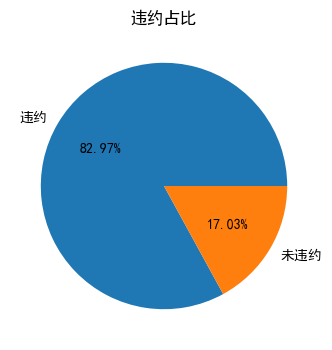

In [434]:
plt.figure(figsize=(4,4))
plt.pie(loan_data_clean['isDefault'].value_counts(),labels=['违约','未违约'],autopct='%1.2f%%')
plt.title('违约占比')

可以看出违约数量相较未违约较少，但并不极度稀少（类似癌症肿瘤）

<b>3.2贷款金额分布情况

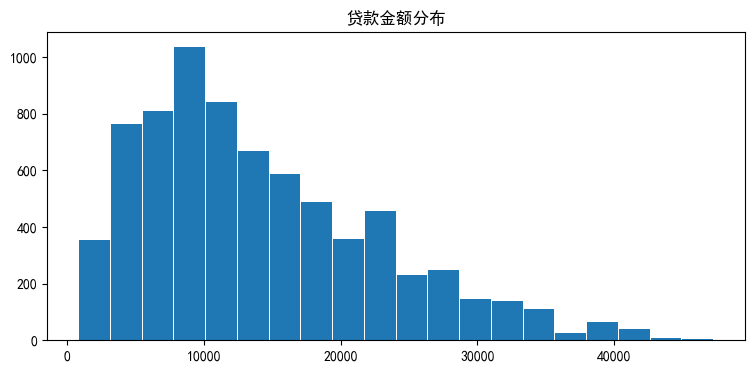

In [435]:
plt.figure(figsize=(9,4))
plt.hist(loan_data_clean['total_loan'],bins=20,rwidth=0.97)
plt.title('贷款金额分布')
plt.show()

可以看出大部分金额集中在10000左右

<b>3.3贷款金额和月供关系

In [436]:
loan_data_clean['year_of_loan'].value_counts()

3    5602
5    1775
Name: year_of_loan, dtype: int64

贷款年份主只有3年和5年两种

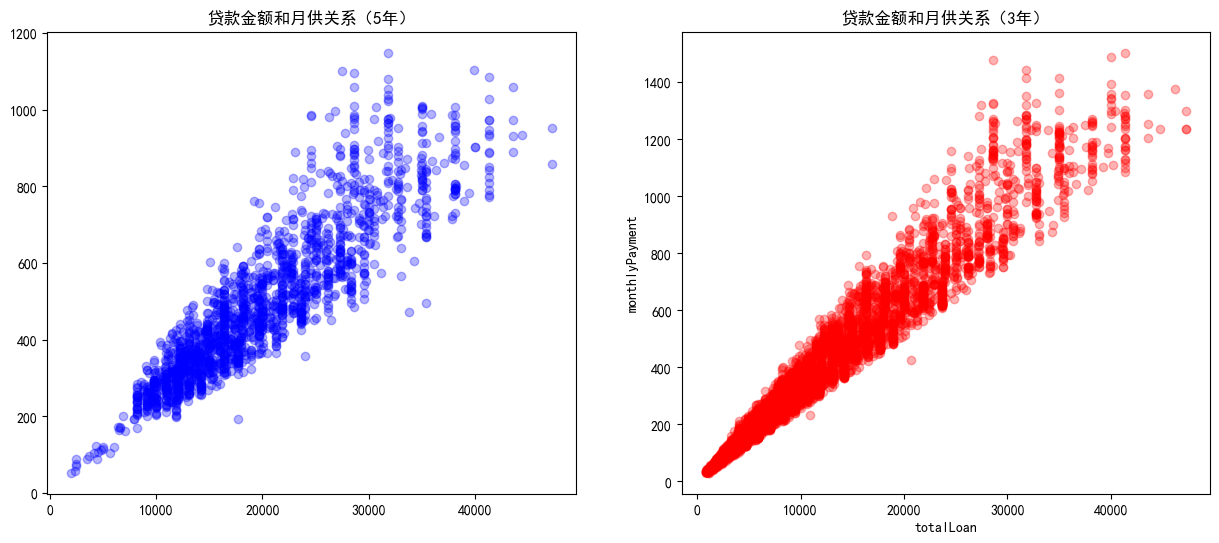

In [437]:
plt.figure(figsize=(15,6))
year5 = loan_data_clean[loan_data_clean['year_of_loan']==5]
year3 = loan_data_clean[loan_data_clean['year_of_loan']==3]

plt.subplot(1,2,1)
plt.scatter(year5.total_loan,year5.monthly_payment,alpha=0.3,color='b')
plt.title('贷款金额和月供关系（5年）')

plt.subplot(1,2,2)
plt.scatter(year3.total_loan,year3.monthly_payment,alpha=0.3,color='r')
plt.xlabel('totalLoan')
plt.ylabel('monthlyPayment')
plt.title('贷款金额和月供关系（3年）')
plt.show()

可以看出月供和贷款金额有着较强的相关性

<b>3.4贷款利率分析

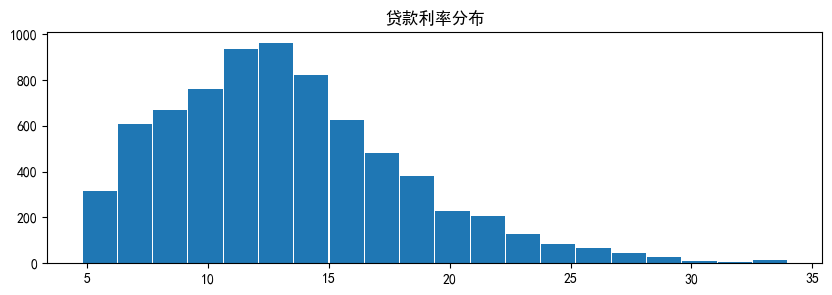

In [438]:
plt.figure(figsize=(10,3))
plt.hist(loan_data_clean['interest'],bins=20,rwidth=0.97)
plt.title('贷款利率分布')
plt.show()

<b>3.5贷款级别分析

In [439]:
loan_data_clean['class'].value_counts()

2    2200
3    2091
1    1249
4    1088
5     523
6     181
7      45
Name: class, dtype: int64

分析贷款级别和是否违约的相关性

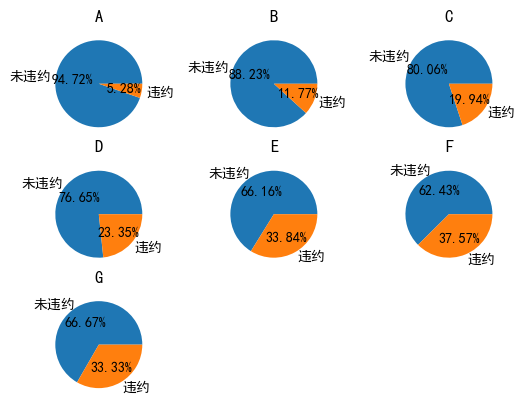

In [440]:
for i,j in zip(range(1,8),['A','B','C','D','E','F','G']):
    plt.subplot(3,3,i)
    data = loan_data_clean[loan_data_clean['class']==i]
    plt.pie(data['isDefault'].value_counts(),labels=['未违约','违约'],autopct='%1.2f%%')
    plt.title(j)

明显可以看到随着贷款等级的增加，违约占比显著增加

<b>3.6所在公司类型和行业分布情况

所在公司类型和行业饼图

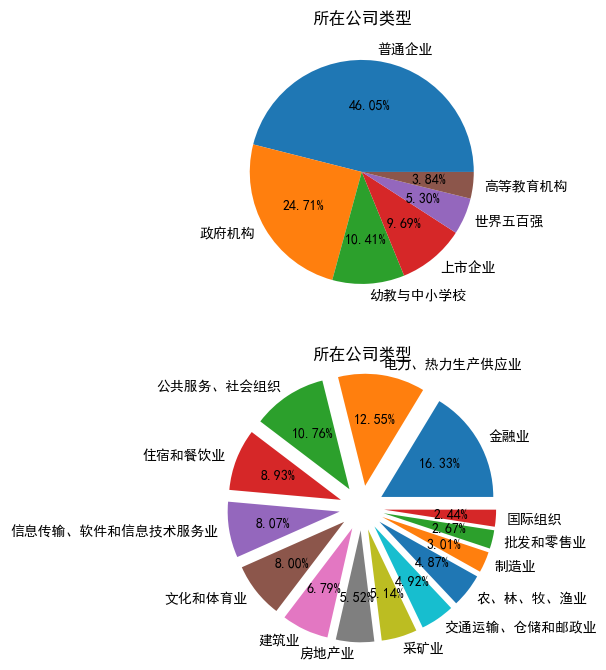

In [441]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.pie(loan_data_clean['employer_type'].value_counts(),labels=loan_data_clean['employer_type'].value_counts().index,autopct='%1.2f%%')
plt.title('所在公司类型')

plt.subplot(2,2,3)
explode=[0.2]*14
plt.pie(loan_data_clean['industry'].value_counts(),explode=explode,labels=loan_data_clean['industry'].value_counts().index,labeldistance=1.1,autopct='%1.2f%%')
plt.title('所在公司类型')
plt.show()

可以看出大部分人在政府机构和普通企业工作

<b>2.5工作年限统计量分析

In [442]:
loan_data_clean=loan_data_clean.drop(index=loan_data_clean[loan_data_clean['work_year']==6.5].index)

In [443]:
y2={}
for i in loan_data_clean['work_year'].value_counts().sort_index().index:
    statics=loan_data_clean[(loan_data_clean['work_year']==i) & (loan_data_clean['isDefault']==1)]['work_year']
    y2[i]=statics.value_counts().iloc[0]

工作年限和违约人数的占比关系

<Figure size 5000x1100 with 0 Axes>

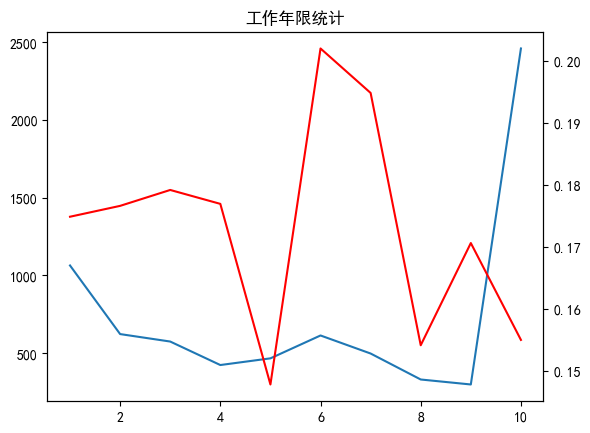

In [444]:
plt.figure(figsize=(50,11),dpi=100)

fig, ax1= plt.subplots()

x1=loan_data_clean['work_year'].value_counts().sort_index().index
y1=loan_data_clean['work_year'].value_counts().sort_index()
ax1.plot(x1,y1,label='workyear')

ax2 = ax1.twinx()
ax2.plot(x1,(pd.Series(y2)/y1),color='r',label='rate')

plt.title('工作年限统计')
plt.show()

蓝色为工作年限，红色为该年限内违约占比，可以看出大部分人集中在10年以上的工龄，并且10年以上违约人数占比较少

<b>3.7各属性之间线性相关性

In [445]:
loan_data_clean.corr().head()

,Unnamed: 0,total_loan,year_of_loan,interest,monthly_payment,class,work_year,house_exist,censor_status,use,...,industry_农、林、牧、渔业,industry_制造业,industry_国际组织,industry_建筑业,industry_房地产业,industry_批发和零售业,industry_文化和体育业,industry_电力、热力生产供应业,industry_采矿业,industry_金融业
Unnamed: 0,1.000000,-0.004196,0.003949,0.004696,-0.004476,0.000140,0.007668,-0.022538,0.005259,-0.002162,...,0.001438,-0.014438,0.007533,-0.011963,0.019656,0.005169,0.003191,-0.011394,0.005806,-0.020427
total_loan,-0.004196,1.000000,0.365180,0.134351,0.924803,0.141842,0.051776,-0.131700,0.212990,-0.161425,...,-0.009963,-0.002455,0.018767,0.009509,-0.008761,-0.012990,-0.006618,0.012627,0.012828,-0.017460
year_of_loan,0.003949,0.365180,1.000000,0.398006,0.136055,0.418344,0.011699,-0.075755,0.137592,-0.090011,...,0.002135,0.000887,0.011527,-0.008564,-0.002258,0.008869,0.006735,0.009340,0.006651,-0.006456
interest,0.004696,0.134351,0.398006,1.000000,0.153395,0.924858,-0.021241,0.055314,0.261525,-0.064442,...,0.000459,0.014588,-0.000669,0.019057,-0.004384,0.024223,-0.009480,-0.026933,0.020026,-0.008545
monthly_payment,-0.004476,0.924803,0.136055,0.153395,1.000000,0.151256,0.051209,-0.105986,0.216433,-0.158719,...,-0.008135,-0.004704,0.015495,0.017932,-0.011974,-0.007614,-0.007458,0.006291,0.018649,-0.016607


将相关系数的矩阵用热力图画出来

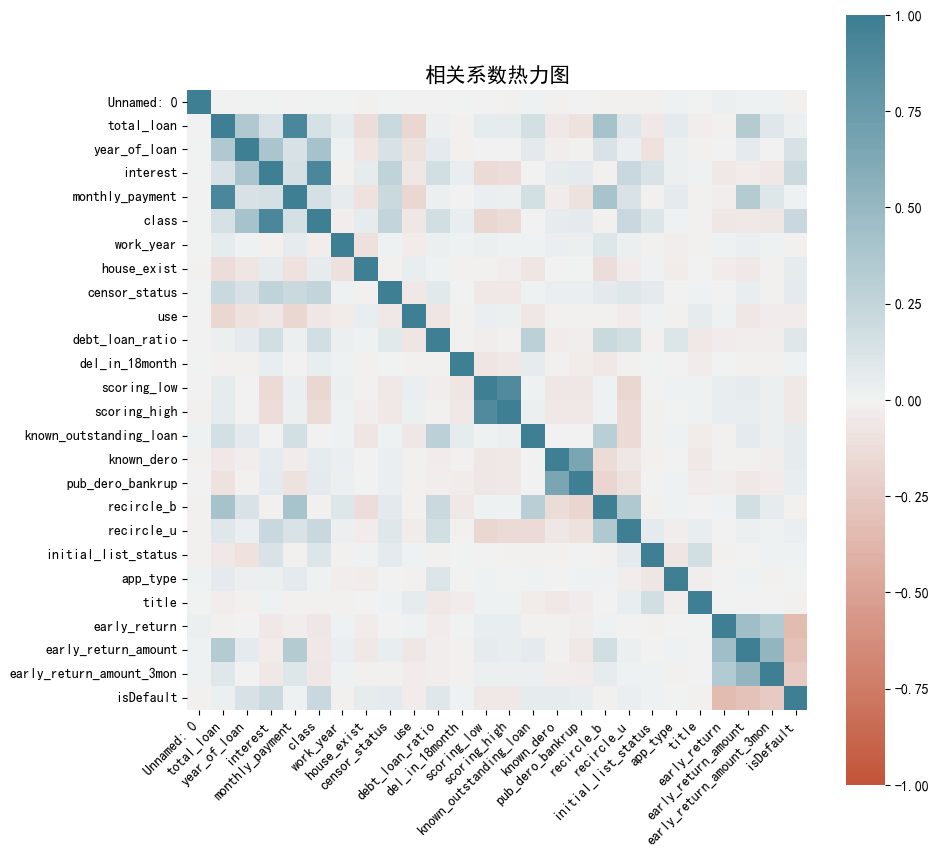

In [446]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    loan_data_clean.iloc[:,[i for i in range(28)]].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),

    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.title("相关系数热力图", fontsize = 15)
plt.show()

**<h3>四、建模**

<b>4.1测试集和训练集

In [447]:
loan_data_clean.drop(['employer_type','industry'],axis=1,inplace=True)

In [448]:
train_target=loan_data_clean['isDefault']
loan_data_clean.drop(['isDefault'],axis=1,inplace=True)
train_data=loan_data_clean

In [449]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_target, stratify=train_target, test_size=0.25, random_state=42)

<b>4.2决策树确定各个特征重要性

Feature importances: 


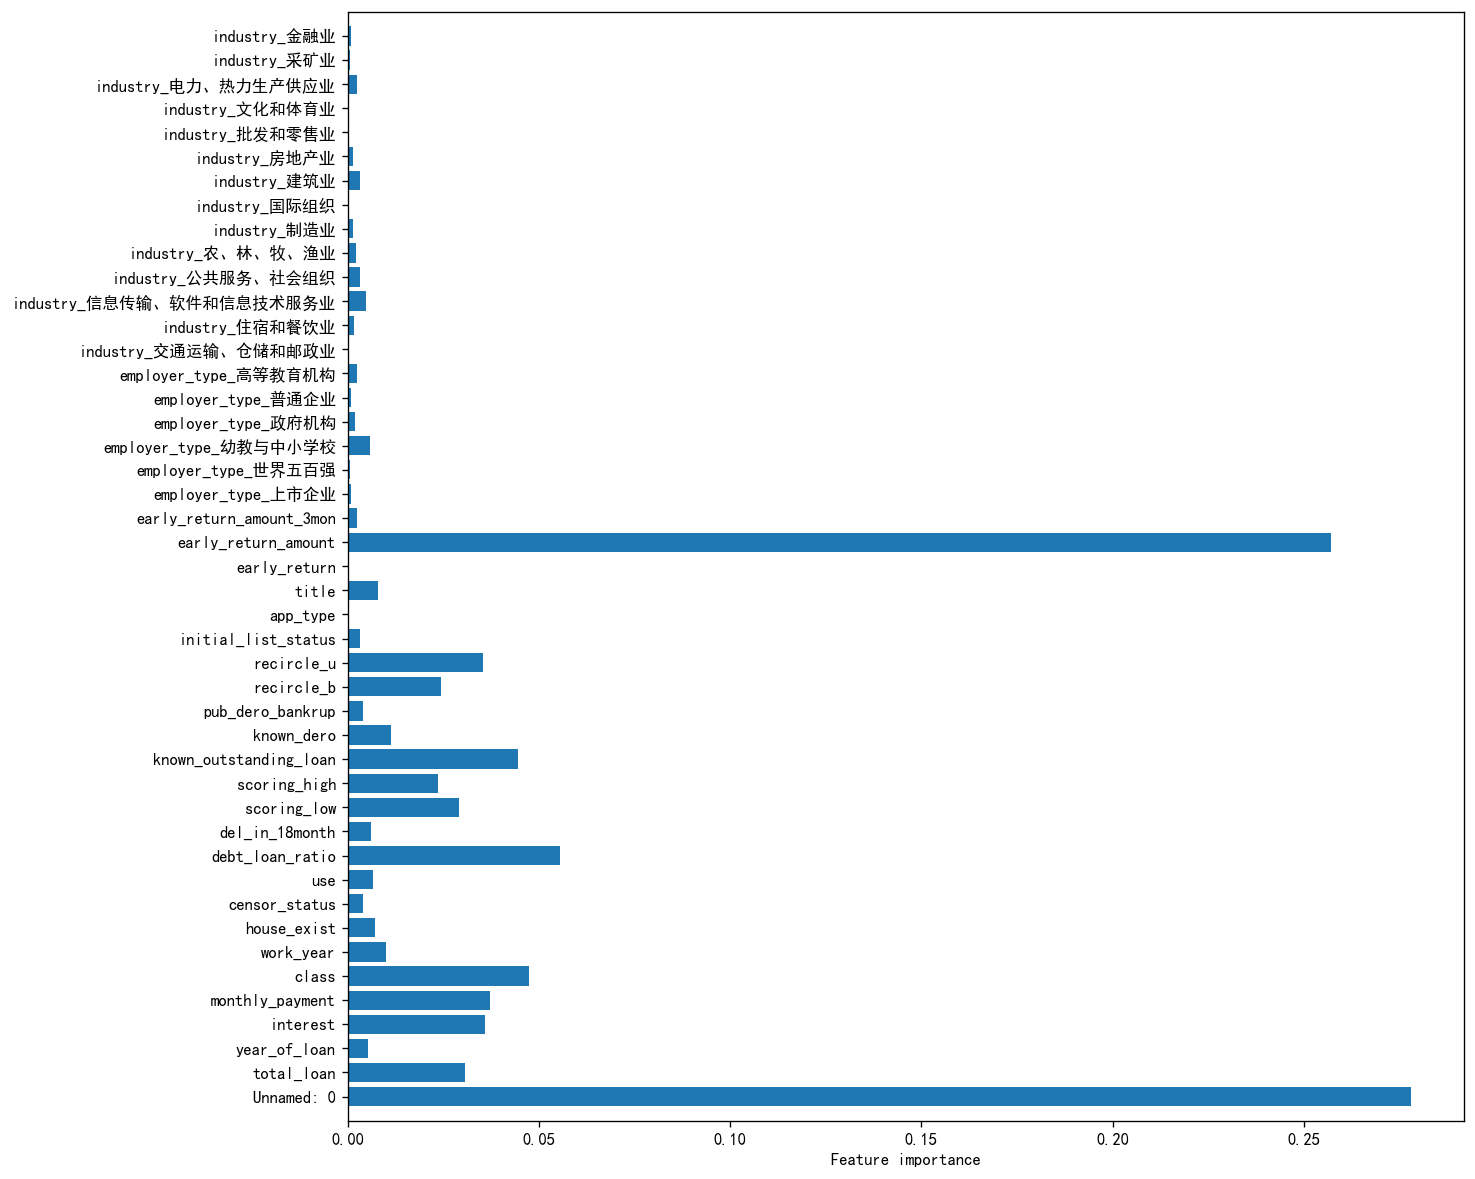

In [450]:
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

n_features = X_train.shape[1]

loan_tree = DecisionTreeClassifier()
loan_tree.fit(X_train,  y_train)

print("Feature importances: ")
plt.figure(figsize=(12, 12), dpi=120)
feat_range = np.arange(X_train.shape[1])
plt.barh(feat_range, loan_tree.feature_importances_, align='center')
plt.yticks(feat_range, X_train.columns)
plt.xlabel("Feature importance")
plt.ylim(-1, n_features);

**4.3模型建立**

**采用𝑘阶近邻算法，模型评估结果采用10折交叉验证测试**

In [451]:
param_grid = [
  {'n_neighbors': [4, 6, 8, 10]}
]

In [452]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)#采用K折交叉验证，折数为10

grid = GridSearchCV(
    KNeighborsClassifier(), param_grid, scoring='f1_macro', cv=kfold, n_jobs=-1
)

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [4, 6, 8, 10]}], scoring='f1_macro')

**4.4计算accuracy、precision、recall**

In [453]:
print("accuracy of training: ", accuracy_score(y_train, grid.predict(X_train)))
print("accuracy of testing:  ", accuracy_score(y_test, grid.predict(X_test)))

accuracy of training:  0.872710788757933
accuracy of testing:   0.8167482327351822


分类报告

In [454]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid.predict(X_test),target_names=["not defalut", "defalut"]))

              precision    recall  f1-score   support

 not defalut       0.84      0.96      0.90      1527
     defalut       0.39      0.14      0.20       312

    accuracy                           0.82      1839
   macro avg       0.62      0.55      0.55      1839
weighted avg       0.77      0.82      0.78      1839



**计算ROC曲线下面积AUC**

In [455]:
from sklearn.metrics import roc_auc_score
trainauc = roc_auc_score(y_train, grid.predict(X_train))
testauc = roc_auc_score(y_test, grid.predict(X_test))
print(f"AUC for train :{trainauc:.3f}" )
print(f"AUC for test :{testauc:.3f}" )

AUC for train :0.653
AUC for test :0.547


**<h3>五、检验模型预测结果**

In [456]:
test_data = pd.read_csv("zhongyuan_test.csv",low_memory=False)

数据处理

In [458]:
#导入测试数据
test_data = test_data.drop(columns = ['loan_id','user_id','issue_date','post_code','region','earlies_credit_mon','policy_code','f0','f1','f2','f3','f4'],axis=1)
#替换缺省值
test_data['work_year'] = test_data['work_year'].str.extract('(\d+)', expand=True)
test_data['work_year'] = test_data['work_year'].map(class_mapping)
test_data.groupby('industry')['work_year']
test_data.groupby('industry')['work_year'].transform("median")
test_data['work_year'].fillna(test_data.groupby('industry')['work_year'].transform("median"), inplace=True)
test_data.dropna(inplace = True)
#变量虚拟化
employer_type_industry_columns_du=pd.get_dummies(test_data[employer_type_industry_columns])
test_data=pd.concat([test_data,employer_type_industry_columns_du],axis=1)
test_data=test_data.replace(class_dict)
#异常值处理
for i in ['debt_loan_ratio', 'known_outstanding_loan', 'early_return_amount']:
    for j in dict_outliers[i].index:
        if j in test_data.index:
            test_data = test_data.drop(labels=j,axis=0)
        else:
            continue
for i in ['recircle_b','early_return_amount_3mon']:
    for j in dict_outliers[i]:
       test_data.replace({i:{j:loan_data_mean[i].mean()}},inplace=True)

用最终的模型预测测试数据并得出分析结果

In [459]:
test_data.drop(['employer_type','industry'],axis=1,inplace=True)
result_target=test_data['isDefault']
test_data.drop(['isDefault'],axis=1,inplace=True)
result_data=test_data

In [464]:
print(classification_report(result_target, grid.predict(result_data),target_names=["not defalut", "defalut"]))

              precision    recall  f1-score   support

 not defalut       0.85      0.97      0.90      2066
     defalut       0.43      0.13      0.20       409

    accuracy                           0.83      2475
   macro avg       0.64      0.55      0.55      2475
weighted avg       0.78      0.83      0.79      2475



最终结果，模型对测试数据预测的结果正确率约为83%<p>
defalut的准确率为43%，召回率为13%<p>
not defalut的准确率为85%，召回率为97%